# Amazon Alexa Review - Sentiment Analysis
Examining the Amazon Alexa dataset and developing classification models to determine whether the sentiment of a given input sentence is positive or negative..

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [7]:
# Loading the data

amazon_data = pd.read_csv('amazon_alexa.tsv', delimiter = '\t', quoting = 3)

In [9]:
amazon_data.shape

(3150, 5)

In [11]:
amazon_data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [15]:
# Checking column names
amazon_data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [19]:
# Checking for any null values
amazon_data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [21]:
# Checking the row for the only null value in the column verigied_reviews
amazon_data[amazon_data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [23]:
# Dropping that record

amazon_data.dropna(inplace = True)

In [25]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

amazon_data['length'] = amazon_data['verified_reviews'].apply(len)

In [27]:
amazon_data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [35]:
#Randomly checking for 10th record
print(amazon_data.iloc[10]['verified_reviews'])
print(len(amazon_data.iloc[10]['verified_reviews']))
print(amazon_data.iloc[10]['length'])

"I sent it to my 85 year old Dad, and he talks to it constantly."
65


np.int64(65)

We can observe that the review length matches the value in the length column for that entry.

#### Checking Datatypes 

In [41]:
amazon_data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

- rating, feedback and length are integer values
- date, variation and verified_reviews are string values

## Analyzing rating column
This column refers to the rating of the variation given by the user

In [47]:
amazon_data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

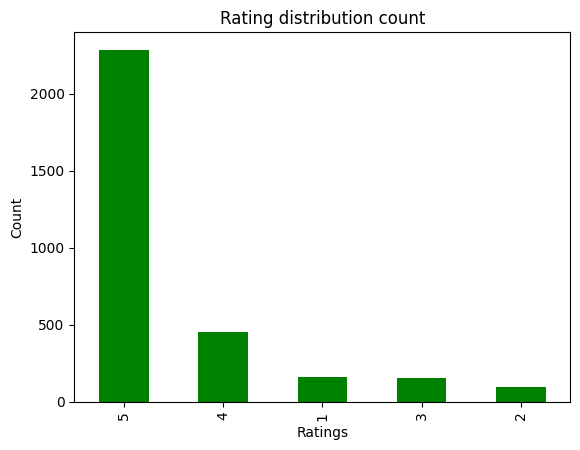

In [51]:
#Bar plot to visualize the total counts of each rating

amazon_data['rating'].value_counts().plot.bar(color = 'green')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

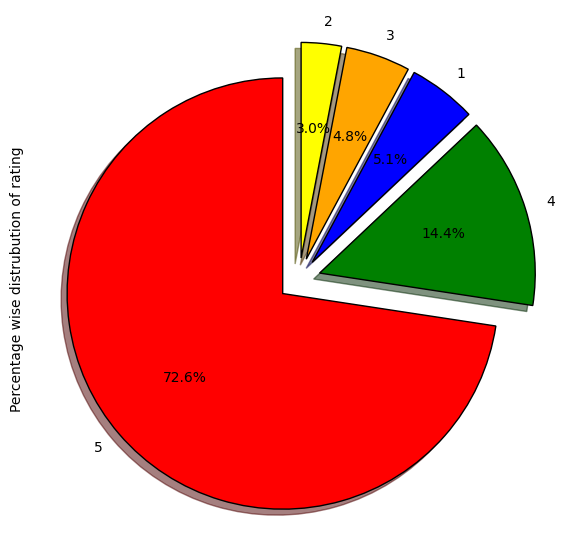

In [61]:
# Plotting the pie chart for % distribution of rating
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = amazon_data['rating'].value_counts()/amazon_data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

## Analyzing Feedback Column
This column refers to the feedback of the verified review

In [65]:
amazon_data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.